# Predicting Whether a Breast Cancer Sample is Benign or Malignant

*This notebooks extends [sklearn_bring_your_own_MLP_Classifier_Breast_Diagnostic.ipynb](https://github.com/aws-samples/aws-healthcare-lifescience-ai-ml-sample-notebooks/blob/main/workshops/Bring_Your_Own_Sklearn_Classifier/byo_mlp_classifier/sklearn_bring_your_own_MLP_Classifier_Breast_Diagnostic.ipynb) by using SageMaker Data Wrangler.*

## Learning Objectives:


1. Understand what SageMaker Script Mode is, and how it can be leveraged.
1. Use SageMaker Data Wrangler data for feature engineering.
1. Use prebuilt SageMaker containers to build, train, and deploy customer sklearn model.
1. Use batch transform to perform inferences and measure model performance.


## Introduction
This is a breast cancer diagnoses dataset, where, for each sample, the sample is diagnosed as "Benign" or "Malignant". For each sample, a number of features are given as well. The source of the dataset is the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

For this model, we will build, train and deploy a [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) using the sklearn library.

To prepare data, we are going to use [SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/).

## Contents

1. [Setup](#Setup)
1. [Process Data](#Process-Data)
    1. [Prepare dataset](#Prepare-dataset)
    1. [Option 1. Create a workflow using Data Wrangler](#Option-1.-Create-a-workflow-using-Data-Wrangler)
    1. [Option 2. Use existing Data Wrangler workflow](#Option-2.-Use-existing-Data-Wrangler-workflow)
    1. [Export to run as a SageMaker Pipeline](#Export-to-run-as-a-SageMaker-Pipeline)
    1. [Run Processing job](#Run-Processing-job)
    1. [Prepare data for training and testing](#Prepare-data-for-training-and-testing)
1. [Train the Model](#Train-the-Model)
1. [Make Batch Predictions](#Make-Batch-Predictions)

## Setup

In [ ]:
# Ensure we have the right version of sagemaker
%pip install sagemaker==2.72.3

In [ ]:
# Import required libraries and initialize necessary clients
import boto3
import matplotlib.pyplot as plt
import pandas
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.s3 import S3Downloader, S3Uploader
from sklearn import model_selection
import sklearn.metrics as metrics

import json
from urllib.parse import urlparse

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

s3_client = boto3.client("s3")
sagemaker_client = boto3.client('sagemaker')

In [ ]:
# Initialize variables
BUCKET = sagemaker_session.default_bucket()
PREFIX = "breast_cancer"
PREFIX_RAW = PREFIX + '/raw'
PREFIX_PROCESSED = PREFIX + '/processed'

# Initialize dataset URL
original_s3_dataset_url = 's3://sagemaker-sample-files/datasets/tabular/breast_cancer/wdbc.csv'
original_s3_dataset_region = 'us-east-1'

# Existing Data Wrangler flow file
hcls_lab_flow_file = 'hcls-lab.flow'

## Process Data

### Prepare dataset

SageMaker Processing job expects S3 inputs to be in the same region. If you are not running notebook from `us-east-1`, code below will created a new bucket, and copy public data set to a private bucket in the region of your SageMaker domain.

In [ ]:
region = boto3.Session().region_name

s3_dataset_url = original_s3_dataset_url

if region != original_s3_dataset_region:
    s3_dataset_path = original_s3_dataset_url[4:]
    s3_dataset_filename = original_s3_dataset_url.split('/')[-1]

    response = s3_client.copy_object(
        Bucket=BUCKET,
        CopySource=s3_dataset_path,
        Key=f'{PREFIX_RAW}/{s3_dataset_filename}',
    )
    
    s3_dataset_url = f's3://{BUCKET}/{PREFIX_RAW}/{s3_dataset_filename}'
    print(f'Copied public dataset to private bucket in region={region}: {s3_dataset_url}')
else:
    print(f'S3 bucket of dataset matches SageMaker domain region={region} and can be used as is: {s3_dataset_url}')

### Use existing Data Wrangler workflow to transform the data

To continue, we will use existing flow from `hcls-lab.flow` file. If you want to start with creating a new flow, you can follow steps in the section`Optional Section: Create a Custom workflow using Data Wrangler`.

Code below depends on [Copy dataset (if your SM domain not in us-east-1)](#Copy-dataset-(if-your-SM-domain-not-in-us-east-1)), so if you skipped it before, now it's time to run it.

In [ ]:
with open(hcls_lab_flow_file, "r") as fr:
    flow_data = json.load(fr)
    source_node = list(filter(lambda n: n['type'] == 'SOURCE', flow_data['nodes']))[0]
    source_node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = s3_dataset_url
                      
with open(hcls_lab_flow_file, "w") as fw:
    json.dump(flow_data, fw, indent=2)

Now you can open existing Data Wrangler flow and view all transformations. To do this navigate to "File Browser" of SageMaker Studio UI and open `hcls-lab.flow` file.

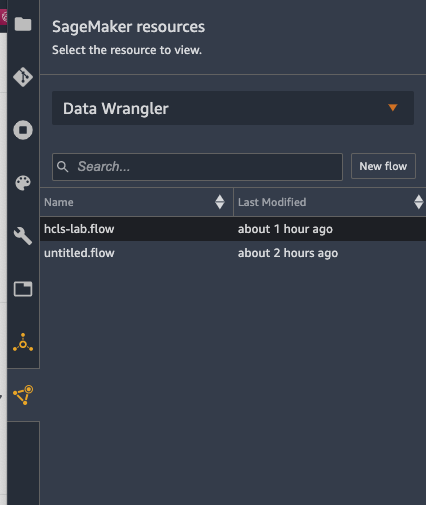

### Export to run as a SageMaker Pipeline

#### 1. Configure Export
![Configure Export](./images/dw_export.png "Configure export")

#### 2. Start Export
![Start Export](./images/dw_export_start.png "Start export")

### Run Processing job

1. Execute notebook code - "Run all cells" from a main menu.
1. Wait until execution finishes (~5 minutes).
1. Check status in Pipelines section of SageMaker resources: open "SageMaker resources" tab, select "Pipelines" and open recently created pipeline.

When the processing job is finished, it will output the location of the processed result in the `S3Output` section. It looks like this:   
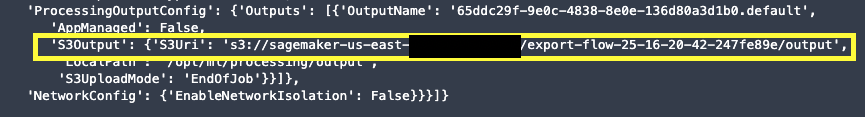

In [ ]:
full_s3_path="Add the S3Output here" #it looks something like this: s3://sagemaker-us-east-1-xxxxxxxxxxxx/export-flow-25-16-20-42-247fe89e/output
full_s3_path="'s3://sagemaker-us-east-1-xxxxxxxxxxxx/export-flow-25-16-20-42-247fe89e/output"
dw_s3_output_bucket=full_s3_path.split("/")[2]
dw_s3_output_prefix="/".join(full_s3_path.split("/")[3:])
#dw_s3_output_bucket=""
#dw_s3_output_prefix=export-flow-25-16-20-42-247fe89e/output"

In [ ]:
# List all S3 objects for the output prefix and get the most recent file
response = s3_client.list_objects(Bucket=dw_s3_output_bucket, Prefix=dw_s3_output_prefix)
dw_s3_output_key=response['Contents'][-1]['Key']

full_data_path=f's3://{dw_s3_output_bucket}/{dw_s3_output_key}'
full_data_file=full_data_path.split('/')[-1]

print(f'full_data_path: {full_data_path}')

In [ ]:
S3Downloader.download(
    s3_uri=full_data_path,
    local_path="data",
    sagemaker_session=sagemaker_session,
)

df_data = pandas.read_csv("data/" + full_data_file)
df_data.head()

#### Split data sets into training and test sets

In [ ]:
# Split the data into training (70%) and test (30%) sets
train_df, test_df = model_selection.train_test_split(df_data, test_size=0.3)
print(f"The train data has shape {train_df.shape}")

In [ ]:
# Process the test data set
y_test = test_df["truth"].tolist()
x_test = test_df.drop(["truth"], axis=1)

print(f"The test data has shape {x_test.shape}")

#### Copy the training and test data sets to s3

In [ ]:
# Copy the training data to s3 so that sagemaker can read it
train_df.to_csv("data/train_data.csv", index=False)
training_data_path = S3Uploader.upload(
    local_path="data/train_data.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX_PROCESSED}",
    sagemaker_session=sagemaker_session,
)

# Do the same for the test data
x_test.to_csv("data/x_test.csv", index=False, header=False)
test_data_path = S3Uploader.upload(
    local_path="data/x_test.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX_PROCESSED}",
    sagemaker_session=sagemaker_session,
)

## Train the Model

#### Define a training script

In [ ]:
%%writefile train.py
import argparse
import joblib
import numpy as np
import os
import pandas as pd
from sklearn.neural_network import MLPClassifier

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument("--output-data-dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    train_data=pd.read_csv(os.path.join(args.train, "train_data.csv"))

    # Extract the labels from the first column
    train_y = train_data["truth"]
    train_X = train_data.drop(["truth"], axis=1)

    # Use scikit-learn's MLP Classifier to train the model.
    regr = MLPClassifier(random_state=1, max_iter=500).fit(train_X, train_y)
    regr.get_params()

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(regr, os.path.join(args.model_dir, "model.joblib"))

def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    regr = joblib.load(os.path.join(model_dir, "model.joblib"))
    return regr

def predict_fn(input_data, model):
    """return the class and the probability of the class"""
    prediction = model.predict(input_data)
    pred_prob = model.predict_proba(input_data) # A numpy array
    return np.array(pred_prob)

In [ ]:
# Create the estimator
sklearn = SKLearn(
    entry_point="train.py",
    instance_type="ml.c4.xlarge",
    role=role,
    py_version="py3",
    framework_version="0.23-1",
    sagemaker_session=sagemaker_session,
)

In [ ]:
# Kick off the training job, it takes ~5 minutes
sklearn.fit({"train": training_data_path})

## Make Batch Predictions

In [ ]:
# Set up a batch transformer for predictions
transformer = sklearn.transformer(
    instance_count=1, instance_type="ml.m4.xlarge", accept="text/csv"
)

In [ ]:
# Start a transform job and wait for it to finish
batch_input_s3 = test_data_path
transformer.transform(batch_input_s3, content_type="text/csv", split_type="Line")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

In [ ]:
# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
print(f"Batch transform results saved to {batch_output}")
S3Downloader.download(
    s3_uri=batch_output,
    local_path="data/output",
    sagemaker_session=sagemaker_session,
)

In [ ]:
# Preview the batch transform results
!head data/output/*

In [ ]:
# Load the predictions and measure performance
predictions = pandas.read_csv("data/output/x_test.csv.out", header=None)
predictions.reset_index(drop=True, inplace=True)
results = pandas.concat([predictions, pandas.Series(y_test)], axis=1)
results.columns = ["pred_0", "pred_1", "true"]
results["true"] = results["true"].astype(int)

In [ ]:
# Plot the AUC-ROC curve
fpr, tpr, threshold = metrics.roc_curve(results["true"], results["pred_1"])
roc_auc = metrics.auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Closing

In this notebook we used SageMaker script mode to build, train, and deploy a sklearn model.
Also, we used SageMaker Data Wrangler for feature engineering.


The Jupyter Notebook that was produced by Data Wrangler during export, was used to define a pipeline. The pipeline included a data processing step that was defined by data flow. There are other ways to export Data Wrangler flows:

* [Python code](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-data-export.html#data-wrangler-data-export-python-code) - a Python file is created containing all steps in your data flow.
* [Feature Store](https://docs.aws.amazon.com/sagemaker/latest/dg/data-wrangler-data-export.html#data-wrangler-data-export-feature-store) - Jupyter Notebook processes your dataset using a SageMaker Data Wrangler job, and then ingests the data into an online and offline feature store.

-----------------------------------------------
### Optional Section: Create a Custom workflow using Data Wrangler

You can follow steps below to create a Data Wrangler flow. Or you skip these steps and use existing flow by following [Option 2. Use existing Data Wrangler workflow](#Option-2.-Use-existing-Data-Wrangler-workflow).

#### 1. Create new Data Wrangler flow

![Create Flow](./images/dw_create_flow.png "Create Flow")

Rename flow. You can choose any name, for example `hcsl-lab-2022`.

![Rename Flow](./images/dw_rename_flow.png "Rename Flow")

#### 2. Configure data import from S3

![S3 Import](./images/dw_import_s3.png "S3 Import")

Configure and start S3 Import.

*If your SageMaker Studio domain is in `us-east-1`, you can use a link to a public data set: `s3://sagemaker-sample-files/datasets/tabular/breast_cancer/wdbc.csv`. Otherwise, use a copy of this file, created in [Prepare dataset](#Prepare-dataset) section.*

![Configure and start S3 Import](./images/dw_import_s3_start.png "Configure and start S3 Import")

#### 3. Add Transformations

!["Add Transform"](./images/dw_transform.png "Add Transform")

Add New Transformation.

!["Add New Transform"](./images/dw_transform_add.png "Add New Transform")

Add Custom transformation to add columns names.

!["Add Transform - Custom"](./images/dw_transform_custom.png "Add Transform - Custom")

Select Pandas:

!["Add Transform - Custom Pandas"](./images/dw_transform_pandas.png "Add Transform - Custom Pandas")

And paste this code:

```python
column_names=[
        "id",
        "diagnosis",
        "radius_mean",
        "texture_mean",
        "perimeter_mean",
        "area_mean",
        "smoothness_mean",
        "compactness_mean",
        "concavity_mean",
        "concave points_mean",
        "symmetry_mean",
        "fractal_dimension_mean",
        "radius_se",
        "texture_se",
        "perimeter_se",
        "area_se",
        "smoothness_se",
        "compactness_se",
        "concavity_se",
        "concave points_se",
        "symmetry_se",
        "fractal_dimension_se",
        "radius_worst",
        "texture_worst",
        "perimeter_worst",
        "area_worst",
        "smoothness_worst",
        "compactness_worst",
        "concavity_worst",
        "concave points_worst",
        "symmetry_worst",
        "fractal_dimension_worst",
    ]

df.columns = column_names
```

Add "Manage Columns" transform and select "Drop column" transform for "id" column.

!["Add Transform - Drop id"](./images/dw_transform_drop_column_id.png "Add Transform - Drop id")

Add "Encode Categorical" transform, choose "One-hot encode" for "diagnosis" column and select "Columns" for Output style.

!["Add Transform - One-hot encode for diagnosis"](./images/dw_transform_encode_categorical.png "Add Transform - One-hot encode for diagnosis")

Add "Manage Columns" transform and select "Drop column" transform for generated above "diagnosis_B" column.

!["Add Transform - Drop diagnosis_B"](./images/dw_transform_drop_column_diagnosisb.png "Add Transform - Drop diagnosis_B")

Add "Manage Columns" transform and select "Rename column" transform for "diagnosis_M" column; set "truth" as a new name.

!["Add Transform - Rename diagnosis_M"](./images/dw_transform_rename.png "Add Transform - Rename diagnosis_M")